In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [2]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Input,Conv1D
from keras.layers import Embedding,LSTM,GlobalMaxPooling1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import Model



Using TensorFlow backend.


In [3]:
twit = pd.read_csv('train.csv')

In [4]:
twit.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
twit_df = twit.drop(columns = ['id','keyword','location'])

In [6]:
twit_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
pd.value_counts(twit_df['target'])

0    4342
1    3271
Name: target, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
print(len(nlp.Defaults.stop_words))
stopwords = (nlp.Defaults.stop_words)

326


In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S\s+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
    
def stop_words(text):
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

In [11]:
twit_df['text'] = twit_df['text'].apply(remove_URL)
twit_df['text'] = twit_df['text'].apply(remove_emoji)
twit_df['text'] = twit_df['text'].map(lambda x: remove_punct(x))
twit_df['text'] = twit_df['text'].map(lambda x: x.lower())
twit_df['text'] = twit_df['text'].apply(stop_words)

twit_df['text'][0:5]

0                deeds reason earthquake allah forgive
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [12]:
X = twit_df['text']
y = twit_df['target']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.33,random_state = 42)

In [14]:
print(X_train.head())
print(X_train.shape)
print('\n\n')

print(y_train.head())

print('\n\n')

print(X_val.head())
print(X_val.shape)

print('\n\n')

print(y_val.head())

5836        photo postapocalypticflimflam prodding rubble
30                                                    end
1879                   man crush everyday cristianinspire
6852    ptsdchat yes feel root shame found rubble trau...
2673    autoames hoped join isis ventilated marines tr...
Name: text, dtype: object
(5100,)



5836    0
30      0
1879    0
6852    1
2673    0
Name: target, dtype: int64



2644            new weapon cause unimaginable destruction
2227    famping things gishwhes got soaked deluge goin...
5448    dt georgegalloway rt gallowaymayor ûïthe col ...
132     aftershock school kick great want thank making...
6845    response trauma children addicts develop defen...
Name: text, dtype: object
(2513,)



2644    1
2227    0
5448    1
132     0
6845    0
Name: target, dtype: int64


In [15]:
from keras.preprocessing.text import Tokenizer

In [16]:
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [17]:
word2idx = tokenizer.word_index

print(X_train_seq[0])
v= len(word2idx)
v
#print(X_val_seq)

[128, 4747, 4748, 503]


13112

In [29]:
#standardize input length by padding and trucating

X_train_data = pad_sequences(X_train_seq,padding='post')

T = X_train_data.shape[1]

X_val_data= pad_sequences(X_val_seq,maxlen=T,padding='post')

In [30]:
T

21

In [31]:
print(X_val_data.shape)

(2513, 21)


In [32]:

D = 20 #embedding dimensionality 
#M=15  #Hidden state dimensionality


i = Input(shape=(T,))
x = Embedding(v+1,D)(i)
x = Conv1D(32,3,activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(64,3,activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation = 'sigmoid')(x)

model = Model(i,x)



In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 21, 20)            262260    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 19, 32)            1952      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 7, 64)             6208      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 128)            2470

In [34]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
output_dir = 'model_output/dense'

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [36]:
r = model.fit(X_train_data,y_train,epochs=10,verbose=1,
         validation_data=(X_val_data,y_val),
         callbacks=[modelcheckpoint])

C:\Users\cbatl\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - ETA: 3:05 - loss: 0.6938 - accuracy: 0.37 - ETA: 31s - loss: 0.6922 - accuracy: 0.5312 - ETA: 17s - loss: 0.6929 - accuracy: 0.517 - ETA: 11s - loss: 0.6918 - accuracy: 0.527 - ETA: 8s - loss: 0.6894 - accuracy: 0.542 - ETA: 7s - loss: 0.6872 - accuracy: 0.55 - ETA: 5s - loss: 0.6826 - accuracy: 0.56 - ETA: 5s - loss: 0.6831 - accuracy: 0.56 - ETA: 4s - loss: 0.6812 - accuracy: 0.56 - ETA: 3s - loss: 0.6817 - accuracy: 0.56 - ETA: 3s - loss: 0.6821 - accuracy: 0.56 - ETA: 3s - loss: 0.6815 - accuracy: 0.55 - ETA: 2s - loss: 0.6809 - accuracy: 0.56 - ETA: 2s - loss: 0.6793 - accuracy: 0.56 - ETA: 2s - loss: 0.6769 - accuracy: 0.57 - ETA: 2s - loss: 0.6744 - accuracy: 0.57 - ETA: 1s - loss: 0.6727 - accuracy: 0.58 - ETA: 1s - loss: 0.6709 - accuracy: 0.59 - ETA: 1s - loss: 0.6664 - accuracy: 0.60 - ETA: 1s - loss: 0.6646 - accuracy: 0.60 - ETA: 1s - loss: 0.6615 - accuracy: 0.60 - ETA:

5100/5100 [==============================] - ETA: 1s - loss: 0.0906 - accuracy: 0.96 - ETA: 1s - loss: 0.0363 - accuracy: 0.98 - ETA: 1s - loss: 0.0302 - accuracy: 0.98 - ETA: 1s - loss: 0.0309 - accuracy: 0.98 - ETA: 1s - loss: 0.0393 - accuracy: 0.98 - ETA: 1s - loss: 0.0427 - accuracy: 0.98 - ETA: 1s - loss: 0.0444 - accuracy: 0.98 - ETA: 1s - loss: 0.0416 - accuracy: 0.98 - ETA: 1s - loss: 0.0427 - accuracy: 0.98 - ETA: 1s - loss: 0.0453 - accuracy: 0.98 - ETA: 1s - loss: 0.0440 - accuracy: 0.98 - ETA: 1s - loss: 0.0425 - accuracy: 0.98 - ETA: 0s - loss: 0.0410 - accuracy: 0.98 - ETA: 0s - loss: 0.0425 - accuracy: 0.98 - ETA: 0s - loss: 0.0412 - accuracy: 0.98 - ETA: 0s - loss: 0.0400 - accuracy: 0.98 - ETA: 0s - loss: 0.0380 - accuracy: 0.98 - ETA: 0s - loss: 0.0365 - accuracy: 0.98 - ETA: 0s - loss: 0.0380 - accuracy: 0.98 - ETA: 0s - loss: 0.0398 - accuracy: 0.98 - ETA: 0s - loss: 0.0417 - accuracy: 0.98 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - ETA: 0s - loss: 0.0424 - accura

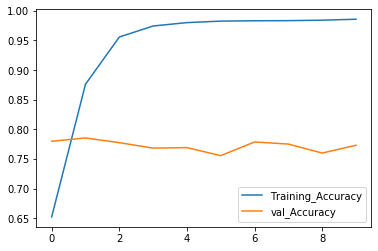

In [37]:
import matplotlib.pyplot as plt

plt.plot(r.history['accuracy'],label = 'Training_Accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_Accuracy')
plt.legend()

In [ ]:
model.load_weights(output_dir+"/weights.09.hdf5")

In [ ]:
y_hat = model.predict(X_val_data)

In [ ]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])


In [ ]:
ydf = pd.DataFrame(list(zip(float_y_hat,y_val)),columns=['y_hat','y_val'])

In [ ]:
ydf